In [1]:
import talib 
from talib import MA_Type
import pandas as pd
import datetime
import pandas as pd
import os
from urllib.request import urlopen
import json
import os 
import numpy as np
import tushare as ts
import pyecharts.options as opts
from pyecharts.charts import Candlestick,Line
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings("ignore")

In [2]:
allticker_path = r'D:\量化\my_team\code\data\day_data'
data_path = r'D:\量化\my_team\code\data'
industry_path = r'D:\量化\my_team\code\data\industry_data'
allticker_file = os.listdir(allticker_path)

In [3]:
df=pd.read_csv(allticker_path+'/AAPL.csv',encoding='GBK')
df.head()

,Date,Open,High,Low,Close,Volume
0,2009-12-31,6.521052,6.527783,6.442419,6.447620,352410800
1,2010-01-04,6.530231,6.562969,6.498105,6.547977,493729600
2,2010-01-05,6.566028,6.596318,6.524722,6.559296,601904800
3,2010-01-06,6.559298,6.585305,6.448233,6.454964,552160000
4,2010-01-07,6.478829,6.486478,6.396218,6.443031,477131200


In [4]:
def MACD_Deviation(df,bottom=True,top=True):
    open_p = df['Open'].values
    high_p = df['High'].values
    close_p = df['Close'].values
    low_p = df['Low'].values
    volume = df["Volume"].values
    volume_p = df["Volume"].values
    df["MACD_DIF"],df["MACD_DEA"],df["MACD_Hist"] = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
    df['JCHA'] = np.where((df["MACD_Hist"] > 0) & (df["MACD_Hist"].shift(1) < 0),1,0) # type: np.ndarray
    df['SCHA']  = np.where((df["MACD_Hist"] < 0) & (df["MACD_Hist"].shift(1) > 0),1,0) # type: np.ndarray
    
    # 判断底背离
    jcha_data = df[df['JCHA']==1]
    jcha_data.reset_index(drop=True,inplace=True)

    jcha_data['pct_chg'] = 100*jcha_data['Close'].pct_change()
    jcha_data['DIF_chg'] = 100*jcha_data['MACD_DIF'].pct_change()
    jcha_data['FLAG']=None
    for i in range(1,len(jcha_data)):
        if i >=len(jcha_data):
            pass
        # 构造有效金叉
        elif (pd.to_datetime(jcha_data.loc[i,'Date'])-pd.to_datetime(jcha_data.loc[i-1,'Date'])).days < 20:
            jcha_data.drop(index=[i],inplace=True)
            jcha_data.reset_index(drop=True,inplace=True)
            if i >=len(jcha_data):
                pass
            else:
                date_0 = jcha_data.loc[i-1,'Date']
                date_1 = jcha_data.loc[i,'Date']
                df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
                if len(df_1[df_1['MACD_DEA']>0]):
                    jcha_data.loc[i,'FLAG']=0
                else:
                    jcha_data.loc[i,'FLAG']=1
        else:
            date_0 = jcha_data.loc[i-1,'Date']
            date_1 = jcha_data.loc[i,'Date']
            df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
            if len(df_1[df_1['MACD_DEA']>0]):
                jcha_data.loc[i,'FLAG']=0
            else:
                jcha_data.loc[i,'FLAG']=1
    jcha_data['JCHA_FLAG'] = np.where(( (jcha_data['pct_chg']<=2) & 
                                       ((abs(jcha_data['pct_chg']) >= abs(jcha_data['DIF_chg'])) | (jcha_data['MACD_DIF']>=jcha_data['MACD_DIF'].shift(1)))
                                       & (jcha_data['FLAG']==1)
                                      ),1,0)

    # 判断顶背离
    scha_data = df.loc[df['SCHA']==1]
    scha_data.reset_index(drop=True,inplace=True)
    scha_data['pct_chg'] = 100*scha_data['Close'].pct_change()
    scha_data['DIF_chg'] = 100*scha_data['MACD_DIF'].pct_change()
    scha_data['FLAG']=None
    # 有效的金叉与死叉的构建还存在问题，有效金叉是指MACDhist能有效稳定持续3天或者5天左右，如果小于3天，则认为是无效金叉/死叉
    for i in range(1,len(scha_data)):
        if i >=len(scha_data):
            pass
        # 构造有效死叉
        elif (pd.to_datetime(scha_data.loc[i,'Date'])-pd.to_datetime(scha_data.loc[i-1,'Date'])).days < 20:
            scha_data.drop(index=[i],inplace=True)
            scha_data.reset_index(drop=True,inplace=True)
            if i >=len(scha_data):
                pass
            else:
                date_0 = scha_data.loc[i-1,'Date']
                date_1 = scha_data.loc[i,'Date']
                df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
                if len(df_1[df_1['MACD_DEA']<0]):
                    scha_data.loc[i,'FLAG']=0
                else:
                    scha_data.loc[i,'FLAG']=1
        else:
            date_0 = scha_data.loc[i-1,'Date']
            date_1 = scha_data.loc[i,'Date']
            df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
            if len(df_1[df_1['MACD_DEA']<0]):
                scha_data.loc[i,'FLAG']=0
            else:
                scha_data.loc[i,'FLAG']=1

    scha_data['SCHA_FLAG'] = np.where(( (scha_data['pct_chg']>=-2) & 

                                    ((abs(scha_data['pct_chg']) >= abs(scha_data['DIF_chg'])) | (scha_data['MACD_DIF']<=scha_data['MACD_DIF'].shift(1)) )
                                       & (scha_data['FLAG']==1)
                                      ),1,0)
    return jcha_data,scha_data

In [98]:
# open_p = df['Open'].values
# high_p = df['High'].values
# close_p = df['Close'].values
# low_p = df['Low'].values
# volume = df["Volume"].values
# volume_p = df["Volume"].values

MACD背离

In [99]:
df["MACD_DIF"],df["MACD_DEA"],df["MACD_Hist"] = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
df.tail()

,Date,Open,High,Low,Close,Volume,MACD_DIF,MACD_DEA,MACD_Hist
2827,2021-03-26,120.349998,121.480003,118.919998,121.209999,94071200,-1.768723,-2.030903,0.262180
2828,2021-03-29,121.650002,122.580002,120.730003,121.389999,80819200,-1.673257,-1.959374,0.286117
2829,2021-03-30,120.110001,120.400002,118.860001,119.900002,85671900,-1.698254,-1.907150,0.208896
2830,2021-03-31,121.650002,123.519997,121.150002,122.150002,118323800,-1.518998,-1.829520,0.310522
2831,2021-04-01,123.660004,124.180000,122.489998,123.000000,75089100,-1.293438,-1.722303,0.428865


In [100]:
# df['JCHA'] = np.where((df["MACD_Hist"] > 0) & (df["MACD_Hist"].shift(1) < 0),1,0) # type: np.ndarray
# df['SCHA']  = np.where((df["MACD_Hist"] < 0) & (df["MACD_Hist"].shift(1) > 0),1,0) # type: np.ndarray

In [235]:
# import warnings
# warnings.filterwarnings("ignore")
# # 判断底背离
# jcha_data = df[df['JCHA']==1]
# jcha_data.reset_index(drop=True,inplace=True)
# jcha_data['Date'] = pd.to_datetime(jcha_data['Date'],format='%Y-%m-%d')
# # 有效金叉的构造
# for i in range(1,len(jcha_data)):
#     if i >=len(jcha_data):
#         pass
#     elif (jcha_data.loc[i,'Date'] - jcha_data.loc[i-1,'Date']).days<20:
        
#         jcha_data.drop(index=[i],inplace=True)
#         jcha_data.reset_index(drop=True,inplace=True)
# jcha_data['pct_chg'] = 100*jcha_data['Close'].pct_change()
# jcha_data['DIF_chg'] = 100*jcha_data['MACD_DIF'].pct_change()
# jcha_data['Date'] = jcha_data['Date'].apply(lambda x:x.strftime('%Y-%m-%d'))
# for i in range(1,len(jcha_data)):
#     date_0 = jcha_data.loc[i-1,'Date']
#     date_1 = jcha_data.loc[i,'Date']
#     df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
#     if len(df_1[df_1['MACD_DEA']>0]):
#         jcha_data.loc[i,'FLAG']=0
#     else:
#         jcha_data.loc[i,'FLAG']=1

# jcha_data['JCHA_FLAG'] = np.where(( (jcha_data['pct_chg']<=0) & 
#                                    ((abs(jcha_data['pct_chg']) >= abs(jcha_data['DIF_chg'])) | (jcha_data['MACD_DIF']>=jcha_data['MACD_DIF'].shift(1)))
#                                    & (jcha_data['FLAG']==1)
#                                   ),1,0)

In [234]:
df_3 = MACD_Deviation(df)
df_3[df_3['JCHA_FLAG']==1]

,Date,Open,High,Low,Close,Volume,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,MACD_corr,pct_chg,DIF_chg,FLAG,JCHA_FLAG
24,2012-12-31,15.759189,16.526885,15.711962,16.427179,659492400,-0.419316,-0.454928,0.035611,1,0,0.417814,-5.123821,-41.666906,1.0,1
25,2013-01-23,15.706096,15.896862,15.581389,15.866611,861509600,-0.307715,-0.323173,0.015458,1,0,0.781944,-3.412441,-26.614936,1.0,1
27,2013-04-26,12.723859,13.002052,12.675425,12.953305,764097600,-0.300674,-0.307164,0.006490,1,0,0.679253,-4.720589,-18.966815,1.0,1
46,2015-10-12,25.819774,25.824354,25.524311,25.560957,121868800,-0.176834,-0.182047,0.005212,1,0,-0.349106,-1.491762,-76.171777,1.0,1
69,2018-12-28,38.194899,38.442257,37.479503,37.886913,169165600,-2.259829,-2.289911,0.030082,1,0,0.885647,-7.610886,4.740634,1.0,1


In [236]:
jcha_data.loc[jcha_data['JCHA_FLAG']==1]

,Date,Open,High,Low,Close,Volume,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,MACD_corr,pct_chg,DIF_chg,FLAG,JCHA_FLAG
24,2012-12-31,15.759189,16.526885,15.711962,16.427179,659492400,-0.419316,-0.454928,0.035611,1,0,0.417814,-5.123821,-41.666906,1.0,1
25,2013-01-23,15.706096,15.896862,15.581389,15.866611,861509600,-0.307715,-0.323173,0.015458,1,0,0.781944,-3.412441,-26.614936,1.0,1
27,2013-04-26,12.723859,13.002052,12.675425,12.953305,764097600,-0.300674,-0.307164,0.006490,1,0,0.679253,-4.720589,-18.966815,1.0,1
46,2015-10-12,25.819774,25.824354,25.524311,25.560957,121868800,-0.176834,-0.182047,0.005212,1,0,-0.349106,-4.206012,-68.041683,1.0,1
69,2018-12-28,38.194899,38.442257,37.479503,37.886913,169165600,-2.259829,-2.289911,0.030082,1,0,0.885647,-15.469093,7.097693,1.0,1


In [240]:
# 判断顶背离
scha_data = df.loc[df['SCHA']==1]
scha_data.reset_index(drop=True,inplace=True)
scha_data['Date'] = pd.to_datetime(scha_data['Date'],format='%Y-%m-%d')
# 有效死叉的构造
for i in range(1,len(scha_data)):
    if i >=len(scha_data):
        pass
    elif (scha_data.loc[i,'Date'] - scha_data.loc[i-1,'Date']).days<20:
        
        scha_data.drop(index=[i],inplace=True)
        scha_data.reset_index(drop=True,inplace=True)
scha_data['pct_chg'] = 100*scha_data['Close'].pct_change()
scha_data['DIF_chg'] = 100*scha_data['MACD_DIF'].pct_change()
scha_data['Date'] = scha_data['Date'].apply(lambda x:x.strftime('%Y-%m-%d'))
for i in range(1,len(scha_data)):
    date_0 = scha_data.loc[i-1,'Date']
    date_1 = scha_data.loc[i,'Date']
    df_1 = df[(df['Date']>=date_0) & (df['Date']<=date_1)]
    if len(df_1[df_1['MACD_DEA']<0]):
        scha_data.loc[i,'FLAG']=0
    else:
        scha_data.loc[i,'FLAG']=1

scha_data['SCHA_FLAG'] = np.where(( (scha_data['pct_chg']>=-2) & 
                                   
                                ((abs(scha_data['pct_chg']) >= abs(scha_data['DIF_chg'])) | (scha_data['MACD_DIF']<=scha_data['MACD_DIF'].shift(1)) )
                                   & (scha_data['FLAG']==1)
                                  ),1,0)

In [248]:
df_j,df_s = MACD_Deviation(df)
# df_j[df_j['JCHA_FLAG']==1]
df_s[df_s['SCHA_FLAG']==1]

,Date,Open,High,Low,Close,Volume,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,pct_chg,DIF_chg,FLAG,SCHA_FLAG
1,2010-10-06,4.212000,4.252000,4.064000,4.092000,1567000,0.036250,0.042713,-0.006463,0,1,-0.679609,-11.072037,1.0,1
13,2012-04-04,7.054000,7.098000,6.938000,7.000000,22409000,0.185952,0.204366,-0.018414,0,1,0.000000,-7.783541,1.0,1
20,2013-02-13,7.660000,7.800000,7.610000,7.690000,4834000,0.223309,0.228378,-0.005069,0,1,14.400475,4.139798,1.0,1
23,2013-07-16,25.256001,25.264000,21.459999,21.809999,161859500,1.466378,1.576920,-0.110542,0,1,17.777297,-37.697996,1.0,1
24,2013-08-14,28.544001,28.968000,27.610001,27.872000,58469000,1.622377,1.642132,-0.019755,0,1,27.794592,10.638393,1.0,1
25,2013-09-09,32.624001,32.900002,31.702000,32.139999,71722500,1.757668,1.896729,-0.139061,0,1,15.312858,8.339078,1.0,1
26,2013-10-03,35.009998,35.938000,33.599998,34.661999,119082500,1.523960,1.714489,-0.190529,0,1,7.846918,-13.296456,1.0,1
32,2014-08-22,50.908001,51.389999,50.521999,51.355999,14167000,1.688483,1.734947,-0.046464,0,1,12.008726,11.473259,1.0,1
40,2015-07-08,51.863998,52.160000,50.862000,50.992001,31105500,1.138562,1.335464,-0.196902,0,1,3.802622,-37.825777,1.0,1
52,2017-02-21,55.090000,56.279999,54.801998,55.478001,28383500,2.332194,2.333539,-0.001345,0,1,11.294337,8.957041,1.0,1


In [241]:
scha_data.loc[scha_data['SCHA_FLAG']==1]

,Date,Open,High,Low,Close,Volume,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,MACD_corr,pct_chg,DIF_chg,FLAG,SCHA_FLAG
1,2010-06-08,7.748279,7.765413,7.516051,7.628646,1000770400,0.037566,0.042367,-0.004801,0,1,0.653437,1.937922,-82.100795,1.0,1
6,2010-12-16,9.824258,9.870766,9.793968,9.829154,322030800,0.108835,0.110317,-0.001482,0,1,0.743442,4.018250,-63.059604,1.0,1
7,2010-12-29,9.981216,9.988254,9.946948,9.952762,163139200,0.107081,0.108105,-0.001024,0,1,0.178127,1.257561,-1.612019,1.0,1
28,2013-06-05,13.928211,14.086668,13.867579,13.911334,290589600,0.114859,0.116533,-0.001674,0,1,0.816242,2.423023,-23.176496,1.0,1
30,2013-11-05,16.503323,16.638916,16.453616,16.530693,265213200,0.316397,0.321637,-0.005240,0,1,0.211193,7.544139,-38.982366,1.0,1
38,2014-07-16,21.728720,21.757849,21.229028,21.237991,213585200,0.337800,0.344745,-0.006946,0,1,0.832988,3.834350,-41.144651,1.0,1
52,2016-09-29,26.472418,26.622138,26.154263,26.243158,143548000,0.429506,0.442976,-0.013471,0,1,-0.024856,3.382164,-31.161678,1.0,1
53,2016-10-21,27.326293,27.349688,27.202306,27.277166,92770800,0.416317,0.434540,-0.018224,0,1,0.931300,3.940105,-3.070797,1.0,1
57,2017-05-22,36.518525,36.656063,36.260051,36.516155,91865600,0.714776,0.716885,-0.002109,0,1,0.451397,12.923111,-28.601484,1.0,1
60,2017-12-26,40.807587,40.967663,40.539993,40.752636,132742000,0.296982,0.340904,-0.043921,0,1,0.760616,-0.309782,-68.191969,1.0,1


In [115]:
import seaborn as sns
# plot = sns.displot(df["MACD_DIF"].values, bins = 100)

In [113]:
# 绘制箱型图
%matplotlib notebook
import matplotlib.pyplot as plt
df["MACD_DIF"].quantile(q=0.98) # 分位数

3.08053750921895

MACD与价格相关系数

In [119]:
df['MA5'] = df.Close.rolling(5).mean()

In [158]:
df['MACD_corr'] = df['Close'].rolling(10).corr(df.MACD_DEA)

In [159]:
df[(df['MACD_corr']<=-0.3)].tail(20)

,Date,Open,High,Low,Close,Volume,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,MACD_corr
2748,2020-12-01,120.829448,123.285777,119.830940,122.536896,128166800,0.807776,0.534598,0.273177,1,0,-0.407181
2774,2021-01-08,132.232389,132.432103,130.035675,131.852966,105158200,2.492631,2.975061,-0.482430,0,0,-0.344789
2783,2021-01-22,136.076657,139.641338,134.818543,138.862503,114459400,2.191465,1.815156,0.376309,1,0,-0.407656
2784,2021-01-25,142.856542,144.873517,136.336271,142.706757,157611700,2.893113,2.030747,0.862366,0,0,-0.461963
2791,2021-02-03,135.557435,135.567429,133.410649,133.740158,89880900,2.047152,2.545590,-0.498438,0,0,-0.464258
2792,2021-02-04,136.096628,137.194977,134.389172,137.184998,84183100,2.072853,2.451043,-0.378190,0,0,-0.619605
2793,2021-02-05,137.350006,137.419998,135.860001,136.759995,75693800,2.035463,2.367927,-0.332464,0,0,-0.720068
2794,2021-02-08,136.029999,136.960007,134.919998,136.910004,71297200,1.994939,2.293329,-0.298390,0,0,-0.551367
2795,2021-02-09,136.619995,137.880005,135.850006,136.009995,76774200,1.868660,2.208395,-0.339735,0,0,-0.323438
2796,2021-02-10,136.479996,136.990005,134.399994,135.389999,73046600,1.698970,2.106510,-0.407541,0,0,-0.497339


<IPython.core.display.Javascript object>


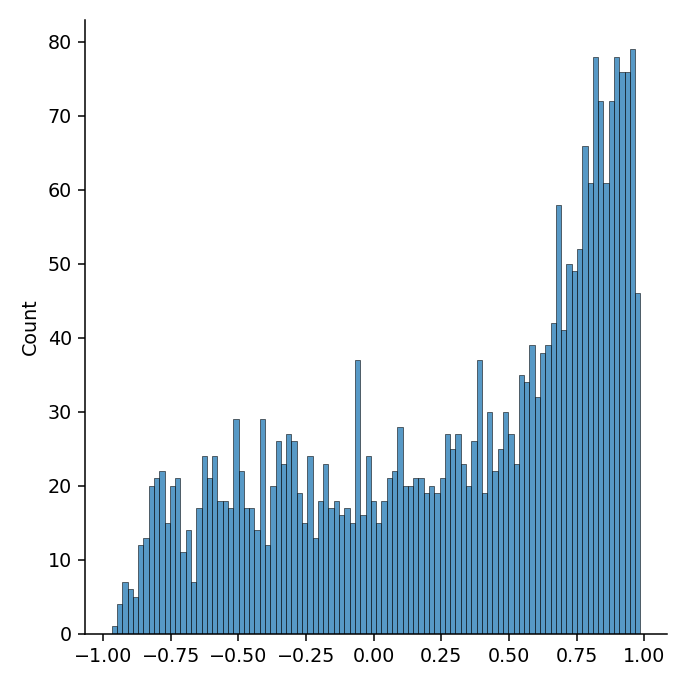

In [116]:
plot = sns.displot(df["MACD_corr"].values, bins = 100)

pyecharts Grid使用


In [155]:
from pyecharts.faker import Faker
from pyecharts import options as opts
from pyecharts.charts import Bar,Kline,Line,Grid,Tab
from pyecharts.globals import ThemeType
import  pyecharts.charts
import pandas as pd

In [166]:
# 把价格数据和相关系数可视化出来
# 用pyecharts 画图
from pyecharts.charts import Line,Page,Grid
from pyecharts import options as opts

page=Page()
line = Line()
# x铀
line.add_xaxis(df.Date.to_list()[-200:])
# 每个y轴
line.add_yaxis('AAPL',df['Close'].round(2).to_list()[-200:],
              label_opts=opts.LabelOpts(is_show=False)
              )


line2 = Line()
# x铀
line2.add_xaxis(df.Date.to_list()[-200:])
# 每个y轴
line2.add_yaxis('AAPL',df['MACD_corr'].round(2).to_list()[-200:],
              label_opts=opts.LabelOpts(is_show=False)
              )
# 图表配置
line.set_global_opts(
                     title_opts=opts.TitleOpts(title='AAPL\n 2010-2020'),
                     tooltip_opts=opts.TooltipOpts(trigger='axis', axis_pointer_type='cross'),
                     yaxis_opts=opts.AxisOpts(min_='dataMin')
                     )
# 图表配置
line2.set_global_opts(
                     title_opts=opts.TitleOpts(title='AAPL\n 2010-2020'),
                     tooltip_opts=opts.TooltipOpts(trigger='axis', axis_pointer_type='cross'),
                     yaxis_opts=opts.AxisOpts(min_='dataMin')
                     )
grid_chart = Grid(init_opts=opts.InitOpts(theme=ThemeType.PURPLE_PASSION))
grid_chart.add(
        line,
        #设置位置
        grid_opts=opts.GridOpts(pos_left="10%", pos_right="8%", height="50%"),
)
grid_chart.add(
        line2,
        grid_opts=opts.GridOpts(
            pos_left="10%", pos_right="8%", pos_top="75%", height="16%"
        ),
)

grid_chart.render_notebook()

# page.add(line)
# page.add(line2)
# line.overlap(line2)
# grid.render_notebook()

A 股选股

In [5]:
import tushare as ta
# 将tushare日期转换成固定格式
def str_to_date(int):
    date = str(int)
    if len(date) == 8:
        return date[0:4] + '-' + date[4:6] + '-' + date[6:8]
    else:
        return date
token = '572c7e13b431da6b7481ca0693db0b56fc83b14bd41055e52e74b459'
pro = ts.pro_api(token)

In [6]:
# 获取正常上市的所有股票代码
def get_allstock_code(exchange='', list_status='L', fields='ts_code'):
    data = pro.stock_basic(exchange=exchange, list_status=list_status, fields=fields)
    return data

In [7]:
# 获取股票数据
def get_stock_data(code, start, end):
    stock_df = pro.daily(ts_code=code, start_date=start, end_date=end)
    stock_df['trade_date'] = stock_df['trade_date'].apply(str_to_date)
    stock_df.sort_values(['trade_date'],inplace=True)
    stock_df.reset_index(drop=True,inplace=True)
    return stock_df

In [48]:
def fuquant(df):
    df['pct_chg'] = df['Close'] / df['pre_close'] - 1
    df['fuquant'] = (1 + df['pct_chg']).cumprod()
    df['Close'] = df['fuquant'] * (df.iloc[0]['Close'] / df.iloc[0]['fuquant'])
    
    # 分别计算当天之后 5 ，10 ，20天的涨跌幅
    df['pct_chg_5'] = (100*(df['Close'].shift(-5)/df['Close'] - 1)).round(2)
    df['pct_chg_10'] = (100*(df['Close'].shift(-10)/df['Close'] - 1)).round(2)
    df['pct_chg_20'] = (100*(df['Close'].shift(-20)/df['Close'] - 1)).round(2)
    df['pct_chg_30'] = (100*(df['Close'].shift(-30)/df['Close'] - 1)).round(2)
    
    return df

In [71]:
start = '20100101'
end = '20210511'
name_dict = {'trade_date':'Date','open':'Open','high':'High',
             'low':'Low','close':'Close','vol':'Volume',
            }

In [50]:
df = get_stock_data('600984.SH', start, end)
df.rename(columns=name_dict,inplace=True) # 列重命名
df.head()

,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount
0,600984.SH,2015-02-25,8.36,8.36,8.36,8.36,7.96,0.40,5.03,5205.07,4351.439
1,600984.SH,2015-02-26,8.78,8.78,8.78,8.78,8.36,0.42,5.02,4310.36,3784.496
2,600984.SH,2015-02-27,9.00,9.00,8.34,8.37,8.78,-0.41,-4.67,119375.14,100837.575
3,600984.SH,2015-03-02,8.32,8.38,8.10,8.25,8.37,-0.12,-1.43,62993.25,51820.582
4,600984.SH,2015-03-03,8.22,8.41,8.20,8.27,8.25,0.02,0.24,52241.28,43357.260


In [51]:
df = fuquant(df)
df.tail(10)

,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount,fuquant,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30
1485,600984.SH,2021-04-23,11.89,11.98,11.65,15.213958,12.05,-0.34,-0.028216,183925.00,216384.168,1.911301,5.55,NaN,NaN,NaN
1486,600984.SH,2021-04-26,11.71,12.75,11.71,15.850579,11.71,0.49,0.041845,273166.06,335544.353,1.991279,-1.07,NaN,NaN,NaN
1487,600984.SH,2021-04-27,12.20,12.28,11.75,15.551757,12.20,-0.23,-0.018852,149958.18,178239.069,1.953738,1.59,NaN,NaN,NaN
1488,600984.SH,2021-04-28,11.89,12.14,11.80,15.577741,11.97,0.02,0.001671,102502.82,122516.916,1.957003,-0.92,NaN,NaN,NaN
1489,600984.SH,2021-04-29,11.89,12.36,11.80,15.915541,11.99,0.26,0.021685,175217.54,213234.907,1.999440,-3.51,NaN,NaN,NaN
1490,600984.SH,2021-04-30,12.21,12.54,11.94,16.058456,12.25,0.11,0.008980,166492.23,203383.959,2.017394,NaN,NaN,NaN,NaN
1491,600984.SH,2021-05-06,12.37,12.49,12.02,15.681680,12.36,-0.29,-0.023463,110640.06,134200.647,1.970060,NaN,NaN,NaN,NaN
1492,600984.SH,2021-05-07,12.05,12.28,11.80,15.798610,12.07,0.09,0.007457,140832.54,170816.120,1.984750,NaN,NaN,NaN,NaN
1493,600984.SH,2021-05-10,12.15,12.21,11.81,15.434826,12.16,-0.28,-0.023026,130685.70,156080.464,1.939049,NaN,NaN,NaN,NaN
1494,600984.SH,2021-05-11,11.88,11.95,11.51,15.356873,11.88,-0.06,-0.005051,138488.90,161715.602,1.929255,NaN,NaN,NaN,NaN


In [26]:
df_j,df_s = MACD_Deviation(df)
df_j
# df_j[df_j['JCHA_FLAG']==1]
# df_j.tail(50)
# df_s[df_s['SCHA_FLAG']==1]

,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount,fuquant,pct_chg_5,pct_chg_10,pct_chg_20,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,DIF_chg,FLAG,JCHA_FLAG
0,600984.SH,2015-04-23,10.50,10.64,10.32,10.360000,10.13,0.23,NaN,59841.84,62971.308,1.301508,-5.791506e-01,-5.501931,23.262548,0.338064,0.332969,0.005095,1,0,NaN,None,0
1,600984.SH,2015-05-14,10.51,10.88,10.42,10.760000,10.51,0.25,3.861004,36955.16,39459.115,1.351759,1.301115e+01,22.583643,35.501859,0.249409,0.237770,0.011639,1,0,-26.224334,0,0
2,600984.SH,2015-07-22,9.16,9.26,8.97,9.160000,9.16,0.00,-14.869888,50642.09,46244.055,1.150754,-3.165939e+00,-4.039301,6.331878,-0.883581,-0.913015,0.029434,1,0,-454.270367,0,0
3,600984.SH,2015-09-16,6.98,7.49,6.98,7.490000,7.13,0.36,-18.231441,30156.74,21957.471,0.940955,7.610147e+00,12.016021,20.427236,-0.501519,-0.512857,0.011338,1,0,-43.240204,1,1
4,600984.SH,2015-11-25,11.03,11.66,11.03,11.580000,11.10,0.48,54.606142,42858.16,48765.329,1.454774,-9.326425e+00,-9.499136,-6.908463,0.515168,0.512241,0.002928,1,0,-202.721595,0,0
5,600984.SH,2015-12-22,11.03,11.05,10.85,11.040000,11.01,0.03,-4.663212,24351.74,26710.735,1.386935,2.173913e+00,-4.619565,-22.916667,0.135076,0.134036,0.001040,1,0,-73.780217,0,0
6,600984.SH,2016-02-02,7.77,8.07,7.77,8.010000,7.77,0.24,-29.177719,18473.66,14620.272,1.006281,7.240949e+00,8.614232,1.373283,-0.651782,-0.663113,0.011331,1,0,-504.354255,0,0
7,600984.SH,2016-03-08,8.07,8.14,7.77,8.120000,8.08,0.04,1.373283,15538.01,12349.512,1.020101,2.832512e+00,8.128079,15.763547,-0.196535,-0.200598,0.004063,1,0,-69.846526,1,1
8,600984.SH,2016-06-01,8.88,8.94,8.79,8.890000,8.90,-0.01,9.482759,61208.52,54359.321,1.116834,-2.137233e+00,-3.487064,-4.161980,-0.131215,-0.136384,0.005169,1,0,-33.235905,0,0
9,600984.SH,2016-06-30,8.40,8.75,8.40,8.650000,8.36,0.29,-2.699663,71418.72,61808.434,1.086683,5.664740e+00,11.098266,10.404624,-0.161806,-0.193494,0.031688,1,0,23.313575,1,0


In [29]:
df_code = get_allstock_code(exchange='', list_status='L', fields='ts_code, name')
df_code

,ts_code,name
0,000001.SZ,平安银行
1,000002.SZ,万科A
2,000004.SZ,国华网安
3,000005.SZ,ST星源
4,000006.SZ,深振业A
...,...,...
4287,688777.SH,中控技术
4288,688788.SH,科思科技
4289,688819.SH,天能股份
4290,688981.SH,中芯国际


In [72]:
all_jchadata = pd.DataFrame()
all_schadata = pd.DataFrame()
for code in df_code.ts_code:
    print(code)
    df = get_stock_data(code, start, end)
    if(len(df)>200):
        df.rename(columns=name_dict,inplace=True) # 列重命名
        df = fuquant(df)
        df_j,df_s = MACD_Deviation(df)
        all_jchadata = all_jchadata.append(df_j[df_j['JCHA_FLAG']==1])
        all_schadata = all_schadata.append(df_s[df_s['SCHA_FLAG']==1])
all_schadata.tail(20)

000001.SZ
000002.SZ
000004.SZ
000005.SZ
000006.SZ
000007.SZ
000008.SZ
000009.SZ
000010.SZ
000011.SZ
000012.SZ
000014.SZ
000016.SZ
000017.SZ
000019.SZ
000020.SZ
000021.SZ
000023.SZ
000025.SZ
000026.SZ
000027.SZ
000028.SZ
000029.SZ
000030.SZ
000031.SZ
000032.SZ
000034.SZ
000035.SZ
000036.SZ
000037.SZ
000038.SZ
000039.SZ
000040.SZ
000042.SZ
000045.SZ
000046.SZ
000048.SZ
000049.SZ
000050.SZ
000055.SZ
000056.SZ
000058.SZ
000059.SZ
000060.SZ
000061.SZ
000062.SZ
000063.SZ
000065.SZ
000066.SZ
000068.SZ
000069.SZ
000070.SZ
000078.SZ
000088.SZ
000089.SZ
000090.SZ
000096.SZ
000099.SZ
000100.SZ
000150.SZ
000151.SZ
000153.SZ
000155.SZ
000156.SZ
000157.SZ
000158.SZ
000159.SZ
000166.SZ
000301.SZ
000333.SZ
000338.SZ
000400.SZ
000401.SZ
000402.SZ
000403.SZ
000404.SZ
000407.SZ
000408.SZ
000409.SZ
000410.SZ
000411.SZ
000413.SZ
000415.SZ
000416.SZ
000417.SZ
000419.SZ
000420.SZ
000421.SZ
000422.SZ
000423.SZ
000425.SZ
000426.SZ
000428.SZ
000429.SZ
000430.SZ
000488.SZ
000498.SZ
000501.SZ
000502.SZ
000503.SZ


002370.SZ
002371.SZ
002372.SZ
002373.SZ
002374.SZ
002375.SZ
002376.SZ
002377.SZ
002378.SZ
002379.SZ
002380.SZ
002381.SZ
002382.SZ
002383.SZ
002384.SZ
002385.SZ
002386.SZ
002387.SZ
002388.SZ
002389.SZ
002390.SZ
002391.SZ
002392.SZ
002393.SZ
002394.SZ
002395.SZ
002396.SZ
002397.SZ
002398.SZ
002399.SZ
002400.SZ
002401.SZ
002402.SZ
002403.SZ
002404.SZ
002405.SZ
002406.SZ
002407.SZ
002408.SZ
002409.SZ
002410.SZ
002411.SZ
002412.SZ
002413.SZ
002414.SZ
002415.SZ
002416.SZ
002417.SZ
002418.SZ
002419.SZ
002420.SZ
002421.SZ
002422.SZ
002423.SZ
002424.SZ
002425.SZ
002426.SZ
002427.SZ
002428.SZ
002429.SZ
002430.SZ
002431.SZ
002432.SZ
002433.SZ
002434.SZ
002435.SZ
002436.SZ
002437.SZ
002438.SZ
002439.SZ
002440.SZ
002441.SZ
002442.SZ
002443.SZ
002444.SZ
002445.SZ
002446.SZ
002447.SZ
002448.SZ
002449.SZ
002451.SZ
002452.SZ
002453.SZ
002454.SZ
002455.SZ
002456.SZ
002457.SZ
002458.SZ
002459.SZ
002460.SZ
002461.SZ
002462.SZ
002463.SZ
002464.SZ
002465.SZ
002466.SZ
002467.SZ
002468.SZ
002469.SZ
002470.SZ


300185.SZ
300187.SZ
300188.SZ
300189.SZ
300190.SZ
300191.SZ
300192.SZ
300193.SZ
300194.SZ
300195.SZ
300196.SZ
300197.SZ
300198.SZ
300199.SZ
300200.SZ
300201.SZ
300202.SZ
300203.SZ
300204.SZ
300205.SZ
300206.SZ
300207.SZ
300208.SZ
300209.SZ
300210.SZ
300211.SZ
300212.SZ
300213.SZ
300214.SZ
300215.SZ
300217.SZ
300218.SZ
300219.SZ
300220.SZ
300221.SZ
300222.SZ
300223.SZ
300224.SZ
300225.SZ
300226.SZ
300227.SZ
300228.SZ
300229.SZ
300230.SZ
300231.SZ
300232.SZ
300233.SZ
300234.SZ
300235.SZ
300236.SZ
300237.SZ
300238.SZ
300239.SZ
300240.SZ
300241.SZ
300242.SZ
300243.SZ
300244.SZ
300245.SZ
300246.SZ
300247.SZ
300248.SZ
300249.SZ
300250.SZ
300251.SZ
300252.SZ
300253.SZ
300254.SZ
300255.SZ
300256.SZ
300257.SZ
300258.SZ
300259.SZ
300260.SZ
300261.SZ
300262.SZ
300263.SZ
300264.SZ
300265.SZ
300266.SZ
300267.SZ
300268.SZ
300269.SZ
300270.SZ
300271.SZ
300272.SZ
300273.SZ
300274.SZ
300275.SZ
300276.SZ
300277.SZ
300278.SZ
300279.SZ
300280.SZ
300281.SZ
300282.SZ
300283.SZ
300284.SZ
300285.SZ
300286.SZ


600068.SH
600070.SH
600071.SH
600072.SH
600073.SH
600075.SH
600076.SH
600077.SH
600078.SH
600079.SH
600080.SH
600081.SH
600082.SH
600083.SH
600084.SH
600085.SH
600088.SH
600089.SH
600090.SH
600091.SH
600093.SH
600094.SH
600095.SH
600096.SH
600097.SH
600098.SH
600099.SH
600100.SH
600101.SH
600103.SH
600104.SH
600105.SH
600106.SH
600107.SH
600108.SH
600109.SH
600110.SH
600111.SH
600112.SH
600113.SH
600114.SH
600115.SH
600116.SH
600117.SH
600118.SH
600119.SH
600120.SH
600121.SH
600122.SH
600123.SH
600125.SH
600126.SH
600127.SH
600128.SH
600129.SH
600130.SH
600131.SH
600132.SH
600133.SH
600135.SH
600136.SH
600137.SH
600138.SH
600139.SH
600141.SH
600143.SH
600145.SH
600146.SH
600148.SH
600149.SH
600150.SH
600151.SH
600152.SH
600153.SH
600155.SH
600156.SH
600157.SH
600158.SH
600159.SH
600160.SH
600161.SH
600162.SH
600163.SH
600165.SH
600166.SH
600167.SH
600168.SH
600169.SH
600170.SH
600171.SH
600172.SH
600173.SH
600176.SH
600177.SH
600178.SH
600179.SH
600180.SH
600182.SH
600183.SH
600184.SH


601229.SH
601231.SH
601233.SH
601236.SH
601238.SH
601258.SH
601279.SH
601288.SH
601298.SH
601311.SH
601318.SH
601319.SH
601326.SH
601328.SH
601330.SH
601333.SH
601336.SH
601339.SH
601360.SH
601366.SH
601368.SH
601369.SH
601375.SH
601377.SH
601388.SH
601390.SH
601398.SH
601399.SH
601456.SH
601500.SH
601512.SH
601515.SH
601518.SH
601519.SH
601555.SH
601566.SH
601567.SH
601568.SH
601577.SH
601579.SH
601588.SH
601595.SH
601598.SH
601599.SH
601600.SH
601601.SH
601606.SH
601607.SH
601608.SH
601609.SH
601611.SH
601615.SH
601616.SH
601618.SH
601619.SH
601628.SH
601633.SH
601636.SH
601658.SH
601666.SH
601668.SH
601669.SH
601677.SH
601678.SH
601686.SH
601688.SH
601689.SH
601696.SH
601698.SH
601699.SH
601700.SH
601702.SH
601717.SH
601718.SH
601727.SH
601766.SH
601777.SH
601778.SH
601788.SH
601789.SH
601798.SH
601799.SH
601800.SH
601801.SH
601808.SH
601811.SH
601816.SH
601818.SH
601827.SH
601828.SH
601838.SH
601857.SH
601858.SH
601860.SH
601865.SH
601866.SH
601869.SH
601872.SH
601877.SH
601878.SH


688138.SH
688139.SH
688155.SH
688156.SH
688157.SH
688158.SH
688159.SH
688160.SH
688165.SH
688166.SH
688168.SH
688169.SH
688177.SH
688178.SH
688179.SH
688180.SH
688181.SH
688183.SH
688185.SH
688186.SH
688188.SH
688189.SH
688191.SH
688195.SH
688196.SH
688198.SH
688199.SH
688200.SH
688201.SH
688202.SH
688208.SH
688215.SH
688218.SH
688219.SH
688221.SH
688222.SH
688228.SH
688229.SH
688233.SH
688256.SH
688258.SH
688260.SH
688266.SH
688268.SH
688277.SH
688278.SH
688286.SH
688288.SH
688289.SH
688298.SH
688299.SH
688300.SH
688301.SH
688308.SH
688309.SH
688310.SH
688311.SH
688312.SH
688313.SH
688315.SH
688316.SH
688317.SH
688318.SH
688321.SH
688323.SH
688328.SH
688329.SH
688330.SH
688333.SH
688335.SH
688336.SH
688338.SH
688339.SH
688350.SH
688355.SH
688356.SH
688357.SH
688358.SH
688360.SH
688363.SH
688365.SH
688366.SH
688368.SH
688369.SH
688377.SH
688378.SH
688379.SH
688383.SH
688386.SH
688388.SH
688389.SH
688390.SH
688393.SH
688395.SH
688396.SH
688398.SH
688399.SH
688408.SH
688418.SH
688456.SH


,ts_code,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount,fuquant,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,MACD_DIF,MACD_DEA,MACD_Hist,JCHA,SCHA,DIF_chg,FLAG,SCHA_FLAG
9,688333.SH,2020-10-26,122.62,123.00,118.00,121.184576,122.62,-1.62,22.992478,7267.04,88107.165,3.672260,-2.80,-3.74,13.80,7.14,8.010088,8.415899,-0.405811,0,1,-24.377005,1,1
10,688333.SH,2020-12-03,132.00,133.00,130.00,130.498763,132.25,-1.95,7.685950,5346.29,69932.705,3.954508,-6.55,-1.29,16.64,6.58,4.068248,4.308975,-0.240728,0,1,-49.210952,1,1
12,688333.SH,2021-02-19,153.00,155.69,149.00,150.439134,156.70,-6.49,6.418704,5715.87,86814.009,4.558762,8.43,8.97,-12.64,-14.91,3.953052,4.548091,-0.595039,0,1,-27.244700,1,1
1,688357.SH,2020-02-24,58.62,59.58,57.76,59.100000,59.16,-0.06,22.487047,12199.13,71337.666,1.365527,-8.26,-13.87,-21.22,-21.22,2.255889,2.294337,-0.038448,0,1,-8.450597,1,1
6,688357.SH,2020-08-07,55.61,55.61,52.36,53.798425,55.78,-2.58,1.720841,7902.25,42345.854,1.243032,27.99,48.52,62.76,48.16,0.540445,0.672257,-0.131812,0,1,-74.215112,1,1
9,688357.SH,2020-10-21,78.78,79.77,77.00,79.807739,78.87,0.05,5.016633,7313.24,57325.874,1.843987,-1.62,-10.17,-17.14,-17.56,2.082388,2.207284,-0.124896,0,1,-57.224395,1,1
3,688358.SH,2020-05-21,75.29,76.50,72.81,73.410000,74.82,-1.41,3.379806,12510.25,93760.035,1.452800,-6.81,-0.71,3.42,18.47,1.297019,1.505420,-0.208401,0,1,-10.593394,1,1
1,688366.SH,2020-02-24,99.29,99.49,96.13,97.660000,99.30,-1.64,13.386741,8767.72,85752.500,1.094475,-7.83,-11.55,-25.97,-19.49,1.601183,1.674407,-0.073224,0,1,-44.228565,1,1
5,688368.SH,2020-09-14,123.96,129.66,123.86,126.987765,125.00,1.20,14.727273,3077.57,38972.452,2.240433,9.75,5.39,17.48,25.89,4.188552,4.230467,-0.041915,0,1,-37.596346,1,1
7,688368.SH,2020-11-11,153.34,154.33,148.00,150.805518,156.29,-6.42,1.085930,1931.22,29157.797,2.660648,10.68,23.04,19.61,12.04,4.523200,5.096547,-0.573347,0,1,-43.949443,1,1


In [32]:
# all_jchadata[all_jchadata['Date']=='2021-04-29']

In [33]:
# all_schadata[all_schadata['Date']=='2021-04-30']

In [73]:
all_jchadata.dropna(inplace=True)
all_schadata.dropna(inplace=True)

In [74]:
all_signal_data = all_jchadata[['ts_code','Date','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30','JCHA_FLAG']]
temp_df = all_schadata[['ts_code','Date','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30','SCHA_FLAG']]
temp_df['SCHA_FLAG'] = 0
temp_df.rename(columns={'SCHA_FLAG':'JCHA_FLAG'},inplace=True)
all_signal_data = all_signal_data.append(temp_df)
all_signal_data.rename(columns={'JCHA_FLAG':'trade_type'},inplace=True)
all_signal_data

,ts_code,Date,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,trade_type
2,000001.SZ,2010-10-11,6.26,4.82,6.10,-7.54,1
5,000001.SZ,2011-01-05,2.95,-2.76,-4.27,-2.20,1
6,000001.SZ,2011-01-31,4.51,4.31,9.34,3.00,1
10,000001.SZ,2011-09-16,-2.24,-5.65,-5.71,-0.12,1
16,000001.SZ,2012-07-30,1.68,1.21,-4.98,-5.25,1
...,...,...,...,...,...,...,...
2,688398.SH,2020-08-11,6.75,-0.46,-5.67,-8.70,0
2,688516.SH,2020-09-22,-5.08,9.41,-0.90,-9.08,0
5,688598.SH,2021-02-03,-3.68,-20.47,-27.71,-26.46,0
2,688599.SH,2020-12-29,2.85,-4.75,12.67,-6.33,0


In [87]:
def report(output_df,up_chg=0,down_chg=0):
    sum_data = len(output_df)
    sum_up = len(output_df[(output_df['trade_type']==1)])
    sum_down = len(output_df[(output_df['trade_type']==0)])
    
    buy_up_5 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_5']>up_chg))])
    buy_up_10 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_10']>up_chg))])
    buy_up_20 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_20']>up_chg))])
    buy_up_30 = len(output_df[((output_df['trade_type']==1) & (output_df['pct_chg_30']>up_chg))])
    
    sell_dwon_5 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_5']<down_chg))])
    sell_dwon_10 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_10']<down_chg))])
    sell_dwon_20 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_20']<down_chg))])
    sell_dwon_30 = len(output_df[((output_df['trade_type']==0) & (output_df['pct_chg_30']<down_chg))])
                    
    print('总数据量:{}'.format(sum_data))
    print('给出做多信号数据量:{}'.format(sum_up))      
    print('给出做空信号数据量:{}'.format(sum_down))
    
    print('在判断为上涨信号时，5天后为上涨的概率:{}'.format(buy_up_5/sum_up))
    print('在判断为上涨信号时，10天后为上涨的概率:{}'.format(buy_up_10/sum_up))
    print('在判断为上涨信号时，20天后为上涨的概率:{}'.format(buy_up_20/sum_up))
    print('在判断为上涨信号时，30天后为上涨的概率:{}'.format(buy_up_30/sum_up))
    print('\n')
    
    print('在判断为下跌信号时，5天后为下跌的概率:{}'.format(sell_dwon_5/sum_down))
    print('在判断为下跌信号时，10天后为下跌的概率:{}'.format(sell_dwon_10/sum_down))
    print('在判断为下跌信号时，20天后为下跌的概率:{}'.format(sell_dwon_20/sum_down))
    print('在判断为下跌信号时，30天后为下跌的概率:{}'.format(sell_dwon_30/sum_down))
    
    print('5天的总体胜率:{}'.format((buy_up_5+sell_dwon_5)/sum_data))
    print('10天的总体胜率:{}'.format((buy_up_10+sell_dwon_10)/sum_data))
    print('20天的总体胜率:{}'.format((buy_up_20+sell_dwon_20)/sum_data))
    print('30天的总体胜率:{}'.format((buy_up_30+sell_dwon_30)/sum_data))
    

In [116]:
up_chg=0
down_chg=0
report(all_signal_data,up_chg,down_chg)

总数据量:55857
给出做多信号数据量:31942
给出做空信号数据量:23915
在判断为上涨信号时，5天后为上涨的概率:0.4824369169119028
在判断为上涨信号时，10天后为上涨的概率:0.5235739778348256
在判断为上涨信号时，20天后为上涨的概率:0.5461461398785299
在判断为上涨信号时，30天后为上涨的概率:0.541262287896813


在判断为下跌信号时，5天后为下跌的概率:0.5014007944804516
在判断为下跌信号时，10天后为下跌的概率:0.5318837549655028
在判断为下跌信号时，20天后为下跌的概率:0.5588542755592725
在判断为下跌信号时，30天后为下跌的概率:0.567760819569308
5天的总体胜率:0.49055624183182056
10天的总体胜率:0.5271317829457365
20天的总体胜率:0.5515870884580267
30天的总体胜率:0.5526075514259627


In [113]:
df = get_stock_data('600584.SH', start, end)
df.rename(columns=name_dict,inplace=True) # 列重命名
df = fuquant(df)
df_j,df_s = MACD_Deviation(df)
df_j = df_j[df_j['JCHA_FLAG']==1]
df_s = df_s[df_s['SCHA_FLAG']==1]
df_j.dropna(inplace=True)
df_s.dropna(inplace=True)
output_data = df_j[['ts_code','Date','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30','JCHA_FLAG']]
temp_df = df_s[['ts_code','Date','pct_chg_5','pct_chg_10','pct_chg_20','pct_chg_30','SCHA_FLAG']]
temp_df['SCHA_FLAG'] = 0
temp_df.rename(columns={'SCHA_FLAG':'JCHA_FLAG'},inplace=True)
output_data = output_data.append(temp_df)
output_data.rename(columns={'JCHA_FLAG':'trade_type'},inplace=True)
output_data.reset_index(drop=True,inplace=True)
output_data

,ts_code,Date,pct_chg_5,pct_chg_10,pct_chg_20,pct_chg_30,trade_type
0,600584.SH,2012-05-31,-6.27,-6.09,-11.44,-16.61,1
1,600584.SH,2015-08-10,-0.24,-23.07,-39.18,-36.93,1
2,600584.SH,2017-01-04,-2.83,-6.49,-2.49,-3.60,1
3,600584.SH,2018-08-13,-1.31,-4.47,-16.50,-25.19,1
4,600584.SH,2018-10-23,-4.94,-0.29,1.71,-1.24,1
5,600584.SH,2018-12-04,-4.33,-9.24,-21.17,-20.31,1
6,600584.SH,2020-10-30,11.16,16.40,15.94,8.24,1
7,600584.SH,2014-08-27,10.80,6.02,12.81,0.57,0
8,600584.SH,2014-10-14,-2.02,-1.76,26.32,23.15,0
9,600584.SH,2015-03-06,-1.53,7.70,24.06,87.86,0


In [114]:
report(output_data,up_chg,down_chg)

总数据量:13
给出做多信号数据量:7
给出做空信号数据量:6
在判断为上涨信号时，5天后为上涨的概率:0.14285714285714285
在判断为上涨信号时，10天后为上涨的概率:0.14285714285714285
在判断为上涨信号时，20天后为上涨的概率:0.2857142857142857
在判断为上涨信号时，30天后为上涨的概率:0.14285714285714285


在判断为下跌信号时，5天后为下跌的概率:0.5
在判断为下跌信号时，10天后为下跌的概率:0.5
在判断为下跌信号时，20天后为下跌的概率:0.3333333333333333
在判断为下跌信号时，30天后为下跌的概率:0.5
5天的总体胜率:0.3076923076923077
10天的总体胜率:0.3076923076923077
20天的总体胜率:0.3076923076923077
30天的总体胜率:0.3076923076923077
